In [53]:
N = 6

# Break Events

## Individual Break Events

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re
from datetime import datetime

# --- Configuration ---
user = "U06"  # Change this to any Uxx (e.g., U01, U03...)

# --- Step 1: Load trial metadata CSV ---
vr_outputs_dir = 'VR Trial Files/output'
metadata_files = [f for f in os.listdir(vr_outputs_dir) if user in f]

if not metadata_files:
    raise FileNotFoundError(f"No metadata file found for {user} in '{vr_outputs_dir}'")
if len(metadata_files) > 1:
    print(f"[Warning] Multiple metadata matches: {metadata_files} — using first match.")

metadata_path = os.path.join(vr_outputs_dir, metadata_files[0])
print(f"[✓] Found metadata file for {user}: {metadata_path}")

try:
    trial_df = pd.read_csv(metadata_path)
except Exception as e:
    raise RuntimeError(f"Failed to read trial metadata file: {e}")

# --- Step 2: Find log folder and latest CSV for each trial ---
logs_base = 'QuestLogs/Logs'
log_folders = [f for f in os.listdir(logs_base) if user in f]

if not log_folders:
    raise FileNotFoundError(f"No log folder found for {user} in '{logs_base}'")
if len(log_folders) > 1:
    print(f"[Warning] Multiple log folders match: {log_folders} — using first match.")

log_folder_path = os.path.join(logs_base, log_folders[0])
print(f"[✓] Using log folder: {log_folder_path}")

log_files = glob.glob(os.path.join(log_folder_path, '*.csv'))
file_dict = {}

pattern = re.compile(rf"{user}_Trial(\d+)_([0-9]{{8}}_[0-9]{{6}})\.csv")

for filepath in log_files:
    match = pattern.search(os.path.basename(filepath))
    if not match:
        continue
    trial_num = int(match.group(1))
    timestamp = datetime.strptime(match.group(2), "%Y%m%d_%H%M%S")
    if trial_num not in file_dict or file_dict[trial_num][1] < timestamp:
        file_dict[trial_num] = (filepath, timestamp)

# --- Step 3: Count break events for each trial ---
break_summaries = []

for trial_num, (file_path, _) in file_dict.items():
    try:
        df = pd.read_csv(file_path)

        if 'TrialTime' not in df.columns or 'broken' not in df.columns:
            print(f"[Skipped] Missing required columns in: {file_path}")
            continue

        df['broken'] = pd.to_numeric(df['broken'], errors='coerce').fillna(0).astype(int)
        df['broken_shifted'] = df['broken'].shift(fill_value=0)
        df['break_event'] = (df['broken'] == 1) & (df['broken_shifted'] == 0)
        break_count = df['break_event'].sum()

        break_summaries.append({
            "Trial": trial_num,
            "Break Events": break_count
        })

        # Optional: save or show plots here if needed
        # ...

    except Exception as e:
        print(f"[Error] Failed to process {file_path}: {e}")

# --- Step 4: Merge and export results ---
break_df = pd.DataFrame(break_summaries)
merged_df = pd.merge(trial_df, break_df, on="Trial", how="left")
merged_df['Break Events'] = merged_df['Break Events'].fillna(0).astype(int)

print(f"\n===== {user} Trial Metadata with Break Events =====")
print(merged_df)

# Optional: Save to CSV
# merged_df.to_csv(f"{user}_trial_summary_with_breaks.csv", index=False)

[✓] Found metadata file for U06: VR Trial Files/output/U06_Pneumatactors_VR.csv
[✓] Using log folder: QuestLogs/Logs/U06 - Luca

===== U06 Trial Metadata with Break Events =====
    Trial        Phase Feedback  Duration  Break Events
0       1     Explore!    Map 0        30             5
1       2        Map 3    Map 3        90             9
2       3        Map 3    Map 3        90            15
3       4        Map 3    Map 3        90             4
4       5        Map 2    Map 2        90             5
5       6        Map 2    Map 2        90            16
6       7        Map 2    Map 2        90            15
7       8        Map 1    Map 1        90            20
8       9        Map 1    Map 1        90            17
9      10        Map 1    Map 1        90             6
10     11  No Feedback    Map 0        90             5
11     12  No Feedback    Map 0        90            25
12     13  No Feedback    Map 0        90            16


## Summarized Break Events

In [ ]:
# --- Step 0: Prepare results container ---
all_merged = []

# --- Step 1: Loop through U01 to U06 ---
for i in range(1, N+1):
    user = f"U{str(i).zfill(2)}"
    print(f"\n=== Processing {user} ===")

    # --- Load trial metadata CSV ---
    vr_outputs_dir = 'VR Trial Files/output'
    metadata_files = [f for f in os.listdir(vr_outputs_dir) if user in f]
    if not metadata_files:
        print(f"[Skipped] No metadata file found for {user}")
        continue
    metadata_path = os.path.join(vr_outputs_dir, metadata_files[0])
    try:
        trial_df = pd.read_csv(metadata_path)
    except Exception as e:
        print(f"[Error] Failed to read metadata for {user}: {e}")
        continue

    # --- Find log folder and latest CSV for each trial ---
    logs_base = 'QuestLogs/Logs'
    log_folders = [f for f in os.listdir(logs_base) if user in f]
    if not log_folders:
        print(f"[Skipped] No logs folder found for {user}")
        continue
    log_folder_path = os.path.join(logs_base, log_folders[0])

    log_files = glob.glob(os.path.join(log_folder_path, '*.csv'))
    file_dict = {}
    pattern = re.compile(rf"{user}_Trial(\d+)_([0-9]{{8}}_[0-9]{{6}})\.csv")

    for filepath in log_files:
        match = pattern.search(os.path.basename(filepath))
        if not match:
            continue
        trial_num = int(match.group(1))
        timestamp = datetime.strptime(match.group(2), "%Y%m%d_%H%M%S")
        if trial_num not in file_dict or file_dict[trial_num][1] < timestamp:
            file_dict[trial_num] = (filepath, timestamp)

    # --- Count break events for each trial ---
    break_summaries = []
    for trial_num, (file_path, _) in file_dict.items():
        try:
            df = pd.read_csv(file_path)
            if 'TrialTime' not in df.columns or 'broken' not in df.columns:
                continue
            df['broken'] = pd.to_numeric(df['broken'], errors='coerce').fillna(0).astype(int)
            df['broken_shifted'] = df['broken'].shift(fill_value=0)
            df['break_event'] = (df['broken'] == 1) & (df['broken_shifted'] == 0)
            break_count = df['break_event'].sum()
            break_summaries.append({
                "Trial": trial_num,
                "Break Events": break_count
            })
        except Exception as e:
            print(f"[Error] {user} Trial {trial_num}: {e}")

    # --- Merge with metadata ---
    break_df = pd.DataFrame(break_summaries)
    merged_df = pd.merge(trial_df, break_df, on="Trial", how="left")
    merged_df['Break Events'] = merged_df['Break Events'].fillna(0).astype(int)
    merged_df['Participant'] = user
    all_merged.append(merged_df)

# --- Step 2: Combine and summarize ---
full_df = pd.concat(all_merged, ignore_index=True)

# ✅ Filter out Explore! trials
full_df = full_df[full_df['Phase'] != 'Explore!']

# Group by Feedback (Map type)
summary = full_df.groupby('Feedback')['Break Events'].agg(
    Total_Breaks='sum',
    Avg_Breaks='mean',
    Std_Breaks='std',       
    Num_Trials='count'
).reset_index()

print("\n===== Summary: Breaks by Feedback Type =====")
print(summary)


=== Processing U01 ===

=== Processing U02 ===

=== Processing U03 ===

=== Processing U04 ===

===== Summary: Breaks by Feedback Type =====
  Feedback  Total_Breaks  Avg_Breaks  Std_Breaks  Num_Trials
0    Map 0           104    8.666667    3.498918          12
1    Map 1            80    6.666667    3.143054          12
2    Map 2            88    7.333333    3.961940          12
3    Map 3            95    7.916667    3.654594          12


# Slip

In [ ]:
# --- Step 0: Prepare results container ---
all_merged = []

# --- Step 1: Loop through U01 to U06 ---
for i in range(1, N+1):
    user = f"U{str(i).zfill(2)}"
    print(f"\n=== Processing {user} ===")

    # --- Load trial metadata CSV ---
    vr_outputs_dir = 'VR Trial Files/output'
    metadata_files = [f for f in os.listdir(vr_outputs_dir) if user in f]
    if not metadata_files:
        print(f"[Skipped] No metadata file found for {user}")
        continue
    metadata_path = os.path.join(vr_outputs_dir, metadata_files[0])
    try:
        trial_df = pd.read_csv(metadata_path)
    except Exception as e:
        print(f"[Error] Failed to read metadata for {user}: {e}")
        continue

    # --- Find log folder and latest CSV for each trial ---
    logs_base = 'QuestLogs/Logs'
    log_folders = [f for f in os.listdir(logs_base) if user in f]
    if not log_folders:
        print(f"[Skipped] No logs folder found for {user}")
        continue
    log_folder_path = os.path.join(logs_base, log_folders[0])

    log_files = glob.glob(os.path.join(log_folder_path, '*.csv'))
    file_dict = {}
    pattern = re.compile(rf"{user}_Trial(\d+)_([0-9]{{8}}_[0-9]{{6}})\.csv")

    for filepath in log_files:
        match = pattern.search(os.path.basename(filepath))
        if not match:
            continue
        trial_num = int(match.group(1))
        timestamp = datetime.strptime(match.group(2), "%Y%m%d_%H%M%S")
        if trial_num not in file_dict or file_dict[trial_num][1] < timestamp:
            file_dict[trial_num] = (filepath, timestamp)

    # --- Step 3: Calculate total peak slip per trial ---
    slip_summaries = []

    for trial_num, (file_path, _) in file_dict.items():
        try:
            df = pd.read_csv(file_path)
            if 'slip' not in df.columns:
                continue

            df['slip'] = pd.to_numeric(df['slip'], errors='coerce').fillna(0)
            slip_values = df['slip'].values
            total_peak_slip = 0
            current_peak = 0

            for val in slip_values:
                if val > 0:
                    current_peak = max(current_peak, val)
                elif val == 0 and current_peak > 0:
                    total_peak_slip += current_peak
                    current_peak = 0

            slip_summaries.append({
                "Trial": trial_num,
                "Total Peak Slip": total_peak_slip
            })

        except Exception as e:
            print(f"[Error] {user} Trial {trial_num}: {e}")

    # --- Merge with metadata ---
    slip_df = pd.DataFrame(slip_summaries)
    merged_df = pd.merge(trial_df, slip_df, on="Trial", how="left")
    merged_df['Total Peak Slip'] = merged_df['Total Peak Slip'].fillna(0)
    merged_df['Participant'] = user
    all_merged.append(merged_df)

# --- Step 4: Combine and summarize ---
full_df = pd.concat(all_merged, ignore_index=True)

# ✅ Filter out Explore! trials
full_df = full_df[full_df['Phase'] != 'Explore!']

# Group by Feedback
summary = full_df.groupby('Feedback')['Total Peak Slip'].agg(
    Total_Slip='sum',
    Avg_Slip='mean',
    Std_Slip='std',
    Num_Trials='count'
).reset_index()

# --- Display ---
print("\n===== Summary: Peak Slip by Feedback Type =====")
print(summary)

# Optional: Save results
# full_df.to_csv("all_participants_with_peak_slip.csv", index=False)
# summary.to_csv("summary_peak_slip_by_map.csv", index=False)


=== Processing U01 ===

=== Processing U02 ===

=== Processing U03 ===

=== Processing U04 ===

===== Summary: Peak Slip by Feedback Type =====
  Feedback  Total_Slip  Avg_Slip  Std_Slip  Num_Trials
0    Map 0     17.8548  1.487900  0.475087          12
1    Map 1     34.8895  2.907458  1.938823          12
2    Map 2     50.4427  4.203558  6.115140          12
3    Map 3     26.2195  2.184958  1.286086          12


# Transfers

     penetrationSource  PenetrationMapped
0   Table Lower Target                 -1
1                 none                  0
2                 none                  0
3                 none                  0
4                 none                  0
5                 none                  0
6                 none                  0
7                 none                  0
8                 none                  0
9                 none                  0
10                none                  0
11                none                  0
12                none                  0
13                none                  0
14                none                  0
15                none                  0
16                none                  0
17                none                  0
18                none                  0
19                none                  0


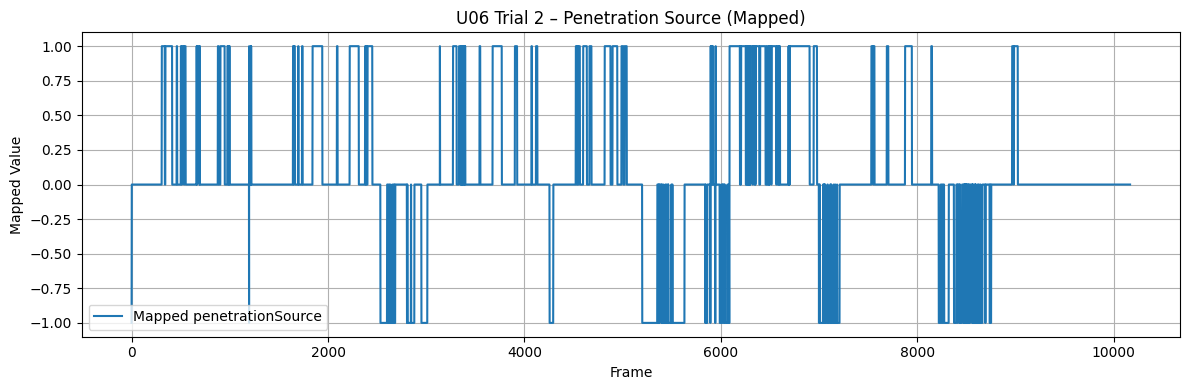

Transfer events detected: 17


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re
from datetime import datetime
import numpy as np

user = "U06"  # Change as needed

# --- Load latest file per trial ---
logs_base = 'QuestLogs/Logs'
log_folders = [f for f in os.listdir(logs_base) if user in f]
log_folder_path = os.path.join(logs_base, log_folders[0])

log_files = glob.glob(os.path.join(log_folder_path, '*.csv'))
pattern = re.compile(rf"{user}_Trial(\d+)_([0-9]{{8}}_[0-9]{{6}})\.csv")
file_dict = {}

for filepath in log_files:
    match = pattern.search(os.path.basename(filepath))
    if not match:
        continue
    trial_num = int(match.group(1))
    timestamp = datetime.strptime(match.group(2), "%Y%m%d_%H%M%S")
    if trial_num not in file_dict or file_dict[trial_num][1] < timestamp:
        file_dict[trial_num] = (filepath, timestamp)

# --- Pick one trial to visualize ---
trial_to_plot = 2  # Change this to whichever trial you want
if trial_to_plot not in file_dict:
    raise ValueError(f"Trial {trial_to_plot} not found for {user}")

file_path = file_dict[trial_to_plot][0]
df = pd.read_csv(file_path)

# --- Normalize to lowercase and map based on substring match ---
df['PenetrationMapped'] = 0
df.loc[df['penetrationSource'].str.contains('upper', case=False, na=False), 'PenetrationMapped'] = 1
df.loc[df['penetrationSource'].str.contains('lower', case=False, na=False), 'PenetrationMapped'] = -1

# --- Print and Plot ---
print(df[['penetrationSource', 'PenetrationMapped']].head(20))  # print first 20 for inspection

plt.figure(figsize=(12, 4))
plt.plot(df['PenetrationMapped'].values, label='Mapped penetrationSource')
plt.title(f'{user} Trial {trial_to_plot} – Penetration Source (Mapped)')
plt.xlabel("Frame")
plt.ylabel("Mapped Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remove consecutive duplicates
pen_array = df['PenetrationMapped'].values
pen_reduced = pen_array[np.insert(np.diff(pen_array) != 0, 0, True)]  # drop duplicates

# Remove 0s (neutral states)
pen_nonzero = pen_reduced[pen_reduced != 0]

# Count sign changes
sign_changes = np.sum(np.diff(pen_nonzero) != 0)

print(f"Transfer events detected: {sign_changes}")

In [72]:
# --- Step 0: Prepare results container ---
all_merged = []

# --- Step 1: Loop through U01 to U06 ---
for i in range(1, N + 1):
    user = f"U{str(i).zfill(2)}"
    print(f"\n=== Processing {user} ===")

    # --- Load trial metadata CSV ---
    vr_outputs_dir = 'VR Trial Files/output'
    metadata_files = [f for f in os.listdir(vr_outputs_dir) if user in f]
    if not metadata_files:
        print(f"[Skipped] No metadata file found for {user}")
        continue
    metadata_path = os.path.join(vr_outputs_dir, metadata_files[0])
    try:
        trial_df = pd.read_csv(metadata_path)
    except Exception as e:
        print(f"[Error] Failed to read metadata for {user}: {e}")
        continue

    # --- Find log folder and latest CSV for each trial ---
    logs_base = 'QuestLogs/Logs'
    log_folders = [f for f in os.listdir(logs_base) if user in f]
    if not log_folders:
        print(f"[Skipped] No logs folder found for {user}")
        continue
    log_folder_path = os.path.join(logs_base, log_folders[0])

    log_files = glob.glob(os.path.join(log_folder_path, '*.csv'))
    file_dict = {}
    pattern = re.compile(rf"{user}_Trial(\d+)_([0-9]{{8}}_[0-9]{{6}})\.csv")

    for filepath in log_files:
        match = pattern.search(os.path.basename(filepath))
        if not match:
            continue
        trial_num = int(match.group(1))
        timestamp = datetime.strptime(match.group(2), "%Y%m%d_%H%M%S")
        if trial_num not in file_dict or file_dict[trial_num][1] < timestamp:
            file_dict[trial_num] = (filepath, timestamp)

    # --- Step 2: Count transfer events per trial ---
    transfer_summaries = []

    for trial_num, (file_path, _) in file_dict.items():
        try:
            df = pd.read_csv(file_path)
            if 'penetrationSource' not in df.columns:
                continue

            # Map to numeric
            df['PenetrationMapped'] = 0
            df.loc[df['penetrationSource'].str.contains('upper', case=False, na=False), 'PenetrationMapped'] = 1
            df.loc[df['penetrationSource'].str.contains('lower', case=False, na=False), 'PenetrationMapped'] = -1

            # Collapse consecutive duplicates
            pen = df['PenetrationMapped'].values
            reduced = pen[np.insert(np.diff(pen) != 0, 0, True)]
            nonzero = reduced[reduced != 0]

            # Count transitions
            transfer_count = np.sum(np.diff(nonzero) != 0)

            transfer_summaries.append({
                "Trial": trial_num,
                "Transfer Events": transfer_count
            })

        except Exception as e:
            print(f"[Error] {user} Trial {trial_num}: {e}")

    # --- Merge with metadata ---
    transfer_df = pd.DataFrame(transfer_summaries)
    if transfer_df.empty or 'Trial' not in transfer_df.columns:
        print(f"[Warning] No valid transfer data found for {user}. Filling with zeros.")
        trial_df['Transfer Events'] = 0
    else:
        trial_df = pd.merge(trial_df, transfer_df, on="Trial", how="left")
        trial_df['Transfer Events'] = trial_df['Transfer Events'].fillna(0).astype(int)

    trial_df['Participant'] = user
    all_merged.append(trial_df)

# --- Step 3: Combine and summarize ---
full_df = pd.concat(all_merged, ignore_index=True)

# ✅ Filter out Explore! trials
full_df = full_df[full_df['Phase'] != 'Explore!']

# Group by Feedback type
summary = full_df.groupby('Feedback')['Transfer Events'].agg(
    Total_Transfers='sum',
    Avg_Transfers='mean',
    Std_Transfers='std',
    Num_Trials='count'
).reset_index()

# --- Display ---
print("\n===== Summary: Transfer Events by Feedback Type =====")
print(summary)


=== Processing U01 ===

=== Processing U02 ===

=== Processing U03 ===

=== Processing U04 ===

=== Processing U05 ===

=== Processing U06 ===

===== Summary: Transfer Events by Feedback Type =====
  Feedback  Total_Transfers  Avg_Transfers  Std_Transfers  Num_Trials
0    Map 0              546      30.333333       6.970526          18
1    Map 1              418      23.222222      10.935939          18
2    Map 2              427      23.722222      10.593036          18
3    Map 3              429      23.833333      10.199481          18
